In [37]:
import warnings 
warnings.filterwarnings("ignore")

import optuna
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix

# Modèle XGBoost
## Import des données

In [16]:
df = pd.read_csv('../data/df_logit_xgb.csv',sep = ',')

## Sélections des variables d'intérêt

In [17]:
df = df[['Motif', 'MT_EAD_DNE_CHR_d', 'MT_EAD_RESID', 'niv_gravite_mtf_dfs',
        'MTF', 'MT_REV_PFI', 'MT_FMG',
       'ANC_PRO_MAX_PFI', 'EAD_1an_avant_def', 'CP',
       'CD_DNE_CHR_LGD_SAIN', 'max_age_ctx', 'TX_APPOR','DET', 'arrete', 'cd_op']]

In [18]:
df['arrete'] = pd.to_datetime(df['arrete'])

## Split des données : Entraînement /  Validation

In [19]:
df_validation = df[df['arrete']>"2021-01-01"]
df_train = df[df['arrete']<"2020-01-02"]

In [20]:
X_train = df_train.select_dtypes(exclude = 'datetime')
X_train.dropna(inplace = True)
X_train.drop(columns = ['cd_op','DET'], inplace = True)

X_test = df_validation.select_dtypes(exclude = 'datetime')
X_test.dropna(inplace = True)
X_test.drop(columns = ['cd_op','DET'], inplace = True)

In [21]:
y_train = df_train['DET']
y_test = df_validation['DET']

## Optimisation des hyperparamètres

In [27]:
def objective(trial):
    params = {'objective': 'binary:logistic',
              'eval_metric': 'logloss',
              'max_depth': trial.suggest_int('max_depth',4, 12),
              'eta': trial.suggest_loguniform('eta', 0.05, 0.4),
              'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
              'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
              'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 75, 125),
              'alpha': trial.suggest_loguniform('alpha', 0.05, 1.0)}

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_prob)
    return roc_auc

In [31]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print(f"Best parameters: {study.best_params}")
print(f"Best AUC score: {study.best_value}")

[I 2024-02-10 16:49:50,940] A new study created in memory with name: no-name-55c761f3-0948-4eb4-9f86-7cac10d90688
[I 2024-02-10 16:49:51,790] Trial 0 finished with value: 0.8164439644141692 and parameters: {'max_depth': 11, 'eta': 0.1603375023462555, 'gamma': 0.00015255910463383458, 'colsample_bytree': 0.5164361480691311, 'subsample': 0.9844859133265035, 'n_estimators': 108, 'alpha': 0.24053697742523558}. Best is trial 0 with value: 0.8164439644141692.
[I 2024-02-10 16:49:52,533] Trial 1 finished with value: 0.8191583843995589 and parameters: {'max_depth': 11, 'eta': 0.09509217079906275, 'gamma': 0.724972904896013, 'colsample_bytree': 0.571196539477247, 'subsample': 0.9660321169724975, 'n_estimators': 85, 'alpha': 0.14888817871140161}. Best is trial 1 with value: 0.8191583843995589.
[I 2024-02-10 16:49:52,753] Trial 2 finished with value: 0.8184022785540465 and parameters: {'max_depth': 8, 'eta': 0.06314339414197509, 'gamma': 1.9309181388489004e-08, 'colsample_bytree': 0.41134097731033

Best parameters: {'max_depth': 5, 'eta': 0.3592980668159282, 'gamma': 4.764224343157684e-08, 'colsample_bytree': 0.9863482723509583, 'subsample': 0.989767140376935, 'n_estimators': 125, 'alpha': 0.8382930501598758}
Best AUC score: 0.8518148866771823


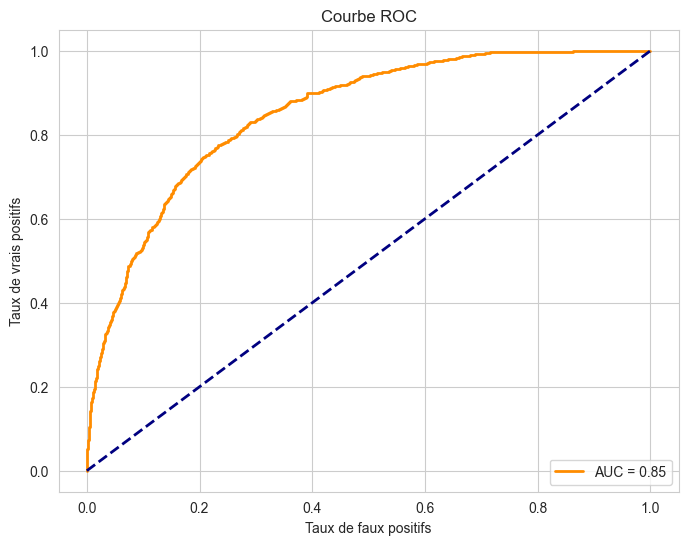

In [32]:
params = study.best_params
model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

In [33]:
y_true = y_test
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_true, y_pred)

# Calcul des métriques à partir de la matrice de confusion
true_positive = conf_matrix[1][1]
false_positive = conf_matrix[0][1]
true_negative = conf_matrix[0][0]
false_negative = conf_matrix[1][0]

# Calcul des métriques
accuracy = accuracy_score(y_true, y_pred)
specificity = true_negative / (true_negative + false_positive)
sensitivity = true_positive / (true_positive + false_negative)

print("Précision (Accuracy): {:.2f}".format(accuracy))
print("Spécificité (Specificity): {:.2f}".format(specificity))
print("Sensibilité (Sensitivity): {:.2f}".format(sensitivity))

Précision (Accuracy): 0.81
Spécificité (Specificity): 0.83
Sensibilité (Sensitivity): 0.70


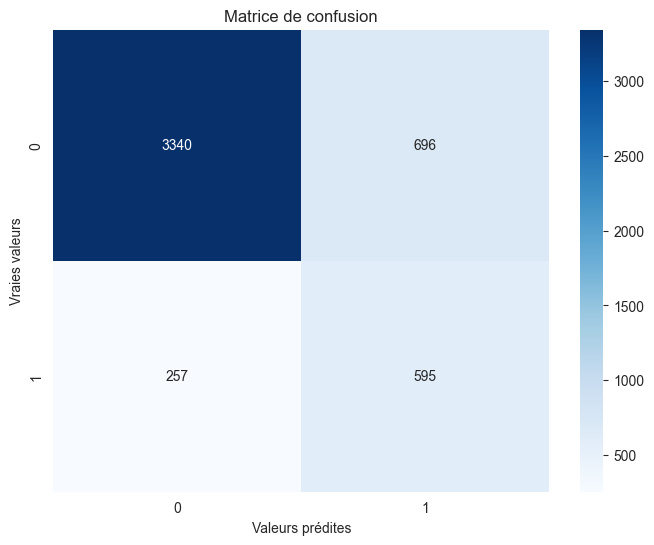

In [34]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de confusion')
plt.show()

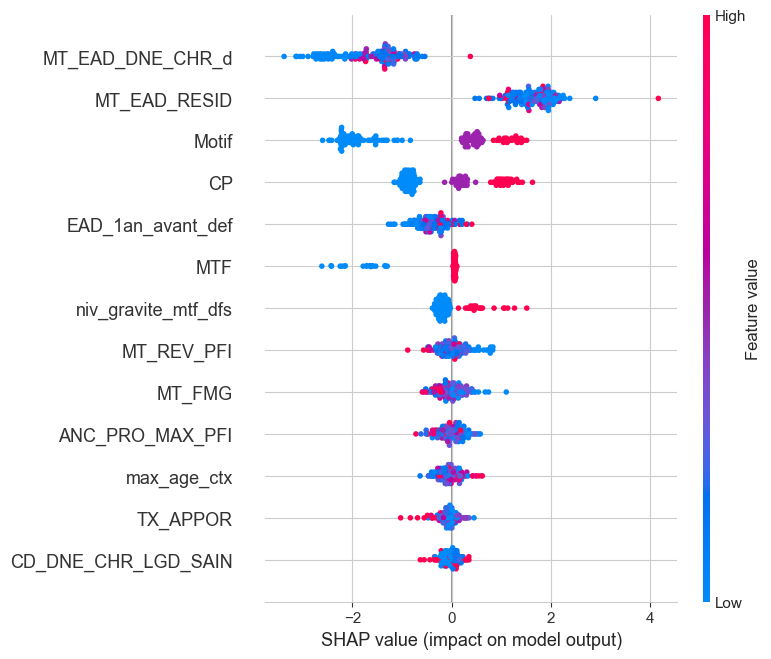

In [35]:
explainer = shap.TreeExplainer(model)

# Calculer les Shapley values pour un échantillon de données
shap_values = explainer.shap_values(X_train.iloc[:150, :])
shap.summary_plot(shap_values, X_train.iloc[:150, :])

shap_values_single = explainer.shap_values(X_train.iloc[[0]])
shap.force_plot(explainer.expected_value, shap_values_single, X_train.iloc[[0]])

In [38]:
shap_values_avg = np.abs(shap_values).mean(axis=0)
top_variables_indices = np.argsort(shap_values_avg)[::-1]


n_top_variables = 15
top_variables = X_train.columns[top_variables_indices[:n_top_variables]]

top_variables

Index(['MT_EAD_DNE_CHR_d', 'MT_EAD_RESID', 'Motif', 'CP', 'EAD_1an_avant_def',
       'MTF', 'niv_gravite_mtf_dfs', 'MT_REV_PFI', 'MT_FMG', 'ANC_PRO_MAX_PFI',
       'max_age_ctx', 'TX_APPOR', 'CD_DNE_CHR_LGD_SAIN'],
      dtype='object')